## **파이썬 머신러닝 완벽 가이드 CH9. 추천시스템 -6,7**

0527 금요일 과제 [필사]

### **06 아이템 기반 최근접 이웃 협업 필터링 실습**

#### **데이터 가공 및 변환**

In [1]:
import pandas as pd
import numpy as np

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


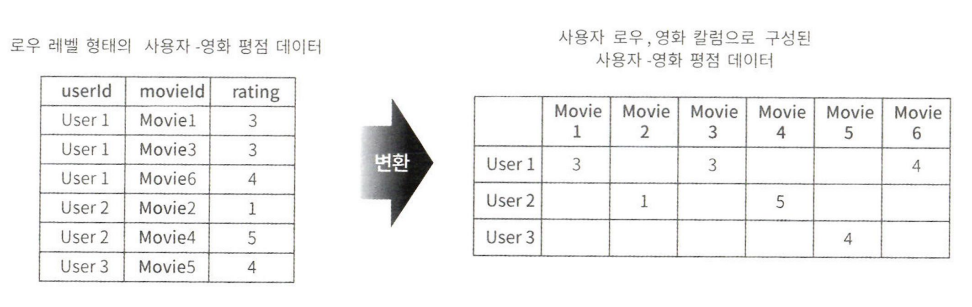

In [2]:
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NaN 값 다수 생성 ∵ 사용자가 평점을 매기지 않은 영화가 칼럼으로 변환되면서 NaN 값을 할당받았음
* 최소 평점이 0.5이므로 NaN = 0 으로 변환

In [3]:
# title 칼럼을 얻기 위해 movies와 조인
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title'로 title 칼럼으로 피벗 수행
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

# NaN 값을 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **영화 간 유사도 산출**



```cosine_similarity()``` 적용하기 위해 ratings_matrix가 행 기준이 영화가 되고, 열 기준이 사용자가 되도록 transpose



In [4]:
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# 직관적인 영화의 유사도 값을 표현하기 위해
# cosine_similarity()로 반환된 넘파이 행렬을 영화명을 매핑해 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns,
                           columns=ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [6]:
# 'Godfather, The (1972)'와 유사도가 높은 상위 6개 추출
item_sim_df['Godfather, The (1972)'].sort_values(ascending=False)[:6]

title
Godfather, The (1972)                        1.000000
Godfather: Part II, The (1974)               0.821773
Goodfellas (1990)                            0.664841
One Flew Over the Cuckoo's Nest (1975)       0.620536
Star Wars: Episode IV - A New Hope (1977)    0.595317
Fargo (1996)                                 0.588614
Name: Godfather, The (1972), dtype: float64

* Godfather: Part II, The (1974)가 가장 유사도가 높다.
* 장르가 완전히 다른 영화도 유사도가 높게 나타난다. (ex. One Flew Over the Cuckoo's Nest (1975) 등)

In [7]:
# 'Inception (2010)'와 유사도가 높은 상위 6개 추출, Inception 제외
item_sim_df['Inception (2010)'].sort_values(ascending=False)[1:6] 

title
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

* Dark Knight, The (2008)이 가장 유사도가 높다.

#### **아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천**

* 영화 유사도 데이터를 이용해 최근접 이웃 협업 필터링으로 개인 최적화
* 아직 관람하지 않은 영화를 추천한다는 특징

[아이템 기반의 협업 필터링에서 개인화된 예측 평점]
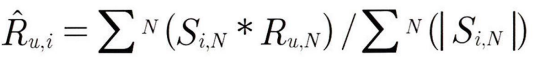

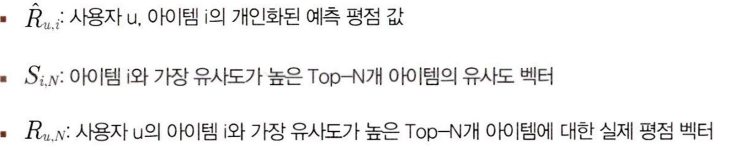

N : 아이템의 최근접 이웃 범위 계수(item neighbor)

In [8]:
def predict_rating(ratings_arr, item_sim_arr):
    ratings_pred = ratings_arr.dot(item_sim_arr)/np.array([np.abs(item_sim_arr).sum(axis=1)])
    return ratings_pred

In [10]:
ratings_pred = predict_rating(ratings_matrix.values, item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index, columns=ratings_matrix.columns)

ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


In [11]:
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE를 구함.
def get_mse(pred, actual):
    # 평점이 있는 실제 영화만 추출
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

print('아이템 기반 모든 최근접 이웃 MSE:', get_mse(ratings_pred, ratings_matrix.values))

아이템 기반 모든 최근접 이웃 MSE: 9.895354759094706


In [12]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
    # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
    pred = np.zeros(ratings_arr.shape)

    # 사용자-아이템 평점 행렬의 열 크기만큼 루프 수행
    for col in range(ratings_arr.shape[1]):
        # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 인덱스 반환
        top_n_items = [np.argsort(item_sim_arr[:,col])[:-n-1:-1]]
        # 개인화된 예측 평점을 계산
        for row in range(ratings_arr.shape[0]):
            pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row,:][top_n_items].T)
            pred[row, col] /= np.sum(np.abs(item_sim_arr[col,:][top_n_items]))

    return pred

In [13]:
ratings_pred = predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n=20)
print('아이템 기반 최근접 TOP-20 이웃 MSE:', get_mse(ratings_pred, ratings_matrix.values))

# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index,
                                   columns=ratings_matrix.columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':


아이템 기반 최근접 TOP-20 이웃 MSE: 3.6949827608772314


* MSE가 약 3.69로 기존의 9.89보다 많이 향상됨.

In [15]:
user_rating_id = ratings_matrix.loc[9,:]
user_rating_id[user_rating_id > 0].sort_values(ascending=False)[:10]

title
Adaptation (2002)                                                                 5.0
Citizen Kane (1941)                                                               5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
Producers, The (1968)                                                             5.0
Lord of the Rings: The Two Towers, The (2002)                                     5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)                         5.0
Back to the Future (1985)                                                         5.0
Austin Powers in Goldmember (2002)                                                5.0
Minority Report (2002)                                                            4.0
Witness (1985)                                                                    4.0
Name: 9, dtype: float64

* 대작 영화나 어드벤처 영화, 코미디 영화 등 전반적으로 흥행성이 좋은 영화에 높은 평점

In [16]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환함.
    # 반환된 user_rating은 영화명(title)을 인덱스로 가지는 Series 객체임
    user_rating = ratings_matrix.loc[userId,:]

    # user_rating이 0보다 크면 기존에 관람한 영화. 대상 인덱스를 추출해 list 객체로 만듦
    already_seen = user_rating[user_rating > 0].index.tolist()

    # 모든 영화명을 list 객체로 만듦
    movies_list = ratings_matrix.columns.tolist()

    # list comprehension으로 already_seen에 해당하는 영화는 movies_list에서 제외함
    unseen_list = [movie for movie in movies_list if movie not in already_seen]

    return unseen_list

In [17]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자 id 인덱스와 unseen_list로 들어온 영화명 칼럼을 추출해
    # 가장 예측 평점이 높은 순으로 정렬함
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

# 사용자가 관람하지 않는 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 최근접 이웃 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 DataFrame으로 생성
recomm_movies = pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index,
                             columns=['pred_score'])
recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591


* 다양하지만 높은 흥행성을 가진 작품 추천

### **07 행렬 분해를 이용한 잠재 요인 협업 필터링 실습**

사용자-아이템 평점 행렬에는 사용자가 평점을 매기지 않은 Null 데이터가 많기 때문에 주로 SGD나 ALS 기반의 행렬 분해 이용
* SGD 기반의 행렬 분해 구현

In [25]:
import numpy as np
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
      
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse

In [26]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda=0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규 분포를 가진 랜덤한 값으로 입력합니다.
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    prev_rmse = 10000
    breadk_count = 0

    # R > 0인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장,
    non_zeros = [(i, j, R[i,j]) for i in range(num_users) for j in range(num_items)if R[i,j] > 0]

    # SGD 기법으로 P와 Q 매트릭스를 계속 업데이트
    for step in range(steps):
        for i,j,r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i,:], Q[j,:].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j,:] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i,:] - r_lambda*Q[j,:])

        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0:
            print('### iteration step:', step, 'rmse:', rmse)

    return P, Q

In [27]:
import pandas as pd
import numpy as np

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
ratings = ratings[['userId','movieId','rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')

# title 칼럼을 얻기 위해 movies와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')
# columns='title'로 title 칼럼으로 pivot 수행
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

In [28]:
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=200, learning_rate=0.01,
                            r_lambda=0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step: 0 rmse: 2.9023619751336867
### iteration step: 10 rmse: 0.7335768591017927
### iteration step: 20 rmse: 0.5115539026853442
### iteration step: 30 rmse: 0.37261628282537446
### iteration step: 40 rmse: 0.2960818299181014
### iteration step: 50 rmse: 0.2520353192341642
### iteration step: 60 rmse: 0.22487503275269854
### iteration step: 70 rmse: 0.2068545530233154
### iteration step: 80 rmse: 0.19413418783028685
### iteration step: 90 rmse: 0.18470082002720403
### iteration step: 100 rmse: 0.17742927527209104
### iteration step: 110 rmse: 0.17165226964707492
### iteration step: 120 rmse: 0.16695181946871723
### iteration step: 130 rmse: 0.16305292191997545
### iteration step: 140 rmse: 0.15976691929679646
### iteration step: 150 rmse: 0.1569598699945732
### iteration step: 160 rmse: 0.1545339818671543
### iteration step: 170 rmse: 0.15241618551077643
### iteration step: 180 rmse: 0.1505508073962831
### iteration step: 190 rmse: 0.14889470913232092


In [29]:
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index=ratings_matrix.index,
                                   columns=ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


In [30]:
# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 잠재 요인 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 DataFrame으로 생성
recomm_movies = pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index,
                             columns=['pred_score'])
recomm_movies

,pred_score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690


* 앞 절의 아이템 기반 협업 필터링 결과와는 추천된 영화가 다르다
    * 'Rear Window (1954)' : 스릴러
    * 'South Park: Bigger, Longer and Uncut (1999)' : 어른을 위한 애니메이션
    * 'Rounders (1998)' : 도박
        * 어둡고 무거운 주제의 영화 추천